In [1]:
import cv2
import os
import numpy as np
import time
from matplotlib import pyplot as plt

In [2]:
plt.rcParams['figure.figsize'] = [30, 15]

In [3]:
detect_on_tiles = 'y'
tiles_x = 2
tiles_y = 3
video_file = '/home/vgoncalves/personal-git/people_detection_compare/resources/virat_dataset/VIRAT_S_010000_00_000000_000165.mp4'
output_video = 'n'
confidence = 0.2

In [4]:
video_file_name = os.path.splitext(os.path.split(video_file)[1])[0]

In [5]:
main_dir = os.path.abspath(os.path.dirname(os.path.abspath(os.getcwd())))

In [6]:
main_dir

'/home/vgoncalves/personal-git/people-detection-compare'

In [7]:
mobile_ssd_dir = os.path.join(main_dir, 'models/mobile_ssd')
prototxt = os.path.join(mobile_ssd_dir, 'MobileNetSSD_deploy.prototxt.txt')
model = os.path.join(mobile_ssd_dir, 'MobileNetSSD_deploy.caffemodel')

In [8]:
classes_path = os.path.sep.join([mobile_ssd_dir, "classes"])
MOBILE_SSD_CLASSES = open(classes_path).read().strip().split("\n")

In [9]:
mobile_ssd_net = cv2.dnn.readNetFromCaffe(prototxt, model)

In [11]:
def tile_image(image, tiles_x, tiles_y):
    rect_dimension_x = image.shape[0] / tiles_x
    rect_dimension_y = image.shape[1] / tiles_y

    tiles = np.zeros((tiles_x, tiles_y), object)

    for tile_x in range(0, tiles_x):
        for tile_y in range(0, tiles_y):
            x = int(tile_x * rect_dimension_x)
            y = int(tile_y * rect_dimension_y)
            final_x = int(x + rect_dimension_x)
            final_y = int(y + rect_dimension_y)

            tile = image[x:final_x, y:final_y]
            tiles[tile_x, tile_y] = tile

    return tiles


In [46]:
def detect_single_frame(model, frame, confidence=0.2, tile_info=None):
    (h, w) = frame.shape[:2]
    blob = cv2.dnn.blobFromImage(cv2.resize(frame, (300, 300)), 0.007843, (300, 300), 127.5)

    # pass the blob through the network and obtain the detections and
    # predictions
    model.setInput(blob)

    start_time = time.time()
    detections = model.forward()
    total_time = time.time() - start_time

    boxes = []
    frame_with_boxes = frame.copy()

    # loop over the detections
    for i in np.arange(0, detections.shape[2]):
        # extract the confidence (i.e., probability) associated with the
        # prediction
        _confidence = detections[0, 0, i, 2]

        # filter out weak detections by ensuring the `confidence` is
        # greater than the minimum confidence
        if _confidence > confidence:
            # extract the index of the class label from the `detections`,
            # then compute the (x, y)-coordinates of the bounding box for
            # the object
            idx = int(detections[0, 0, i, 1])
            if MOBILE_SSD_CLASSES[idx] == 'person':

                box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
                (startX, startY, endX, endY) = box.astype("int")

                if tile_info is not None:
                    startX += tile_info['row']*int(tile_info['dim_y'])
                    startY += tile_info['column']*int(tile_info['dim_x'])
                    endX += tile_info['row']*int(tile_info['dim_y'])
                    endY += tile_info['column']*int(tile_info['dim_x'])
                    
                boxes.append([startX, startY, endX, endY])

                label = "{:.2f}%".format(_confidence * 100)
                cv2.rectangle(frame_with_boxes, (startX, startY), (endX, endY), (0,255,0), 2)
                y = startY - 15 if startY - 15 > 15 else startY + 15
                cv2.putText(frame_with_boxes, label, (startX, y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 2)

    return boxes, total_time, frame_with_boxes


In [10]:
vs = cv2.VideoCapture(video_file)

In [11]:
##read from specific frame
vs.set(cv2.CAP_PROP_POS_FRAMES,560)

True

In [12]:
success, frame = vs.read()

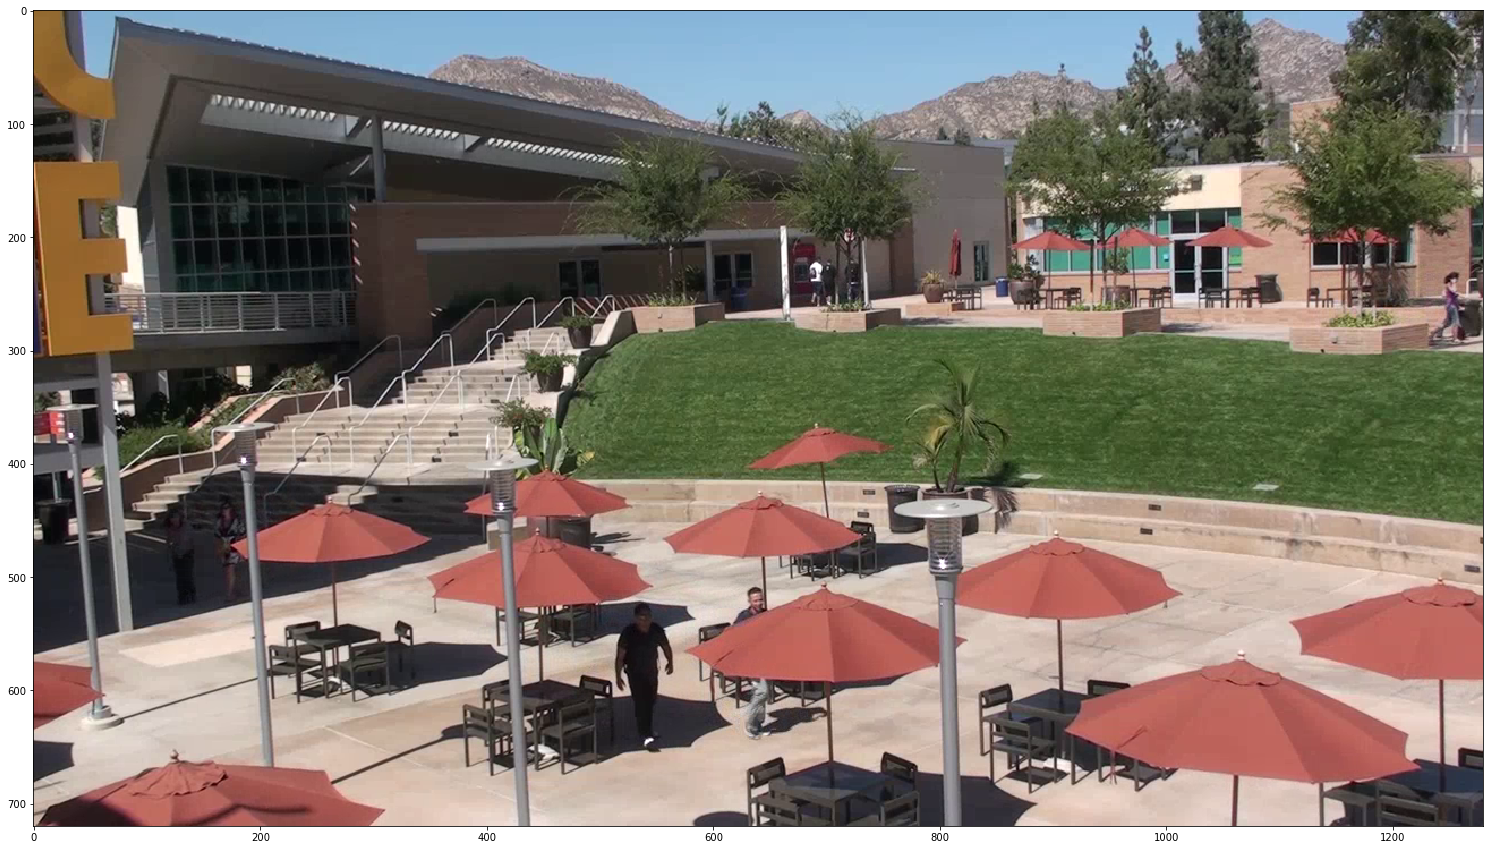

In [55]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plt.show()

In [90]:
frame.shape

(720, 1280, 3)

In [56]:
rect_dimension_x = frame.shape[0] / tiles_x
rect_dimension_y = frame.shape[1] / tiles_y

In [57]:
rect_dimension_x

360.0

In [58]:
rect_dimension_y

426.6666666666667

In [59]:
tiles = tile_image(frame, tiles_x, tiles_y)

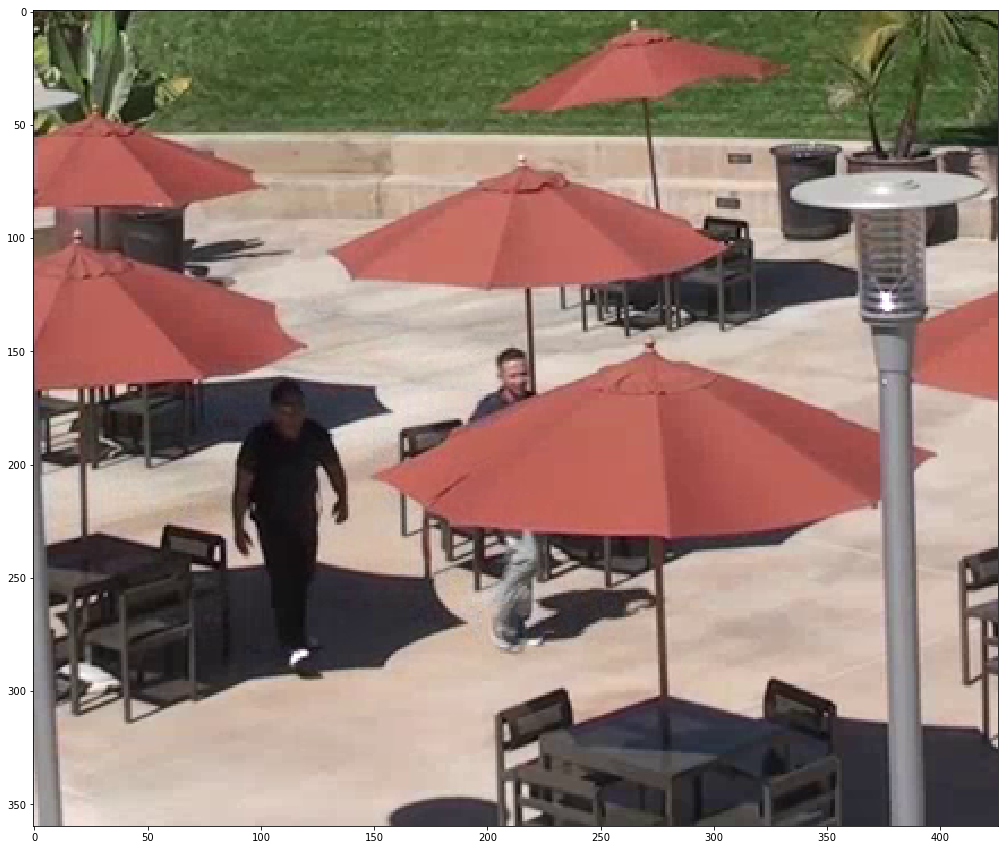

In [60]:
plt.imshow(cv2.cvtColor(tiles[1,1], cv2.COLOR_BGR2RGB))
plt.show()

In [21]:
tiles[1, 1].shape

(360, 426, 3)

In [48]:
boxes, total_time, new_tile_draw = detect_single_frame(mobile_ssd_net, tiles[1, 1], tile_info={'dim_x': 360, 
                                                                                              'dim_y': 426,
                                                                                              'row':1,
                                                                                              'column':1})

In [49]:
boxes

[[492, 523, 550, 644], [585, 508, 631, 628]]

In [42]:
adjusted_boxes = []
row = 1
column = 1

for box in boxes:
    (startX, startY, endX, endY) = box
    startX += row*int(rect_dimension_y)
    startY += column*int(rect_dimension_x)
    endX += row*int(rect_dimension_y)
    endY += column*int(rect_dimension_x)
    #adjusted_boxes.append([startX, startY, endX, endY])
    adjusted_boxes.append([startX, startY, endX, endY])

In [43]:
adjusted_boxes

[[492, 523, 550, 644], [585, 508, 631, 628]]

In [65]:
boxes, total_time, new_tile_draw = detect_single_frame(mobile_ssd_net, tiles[0, 1])

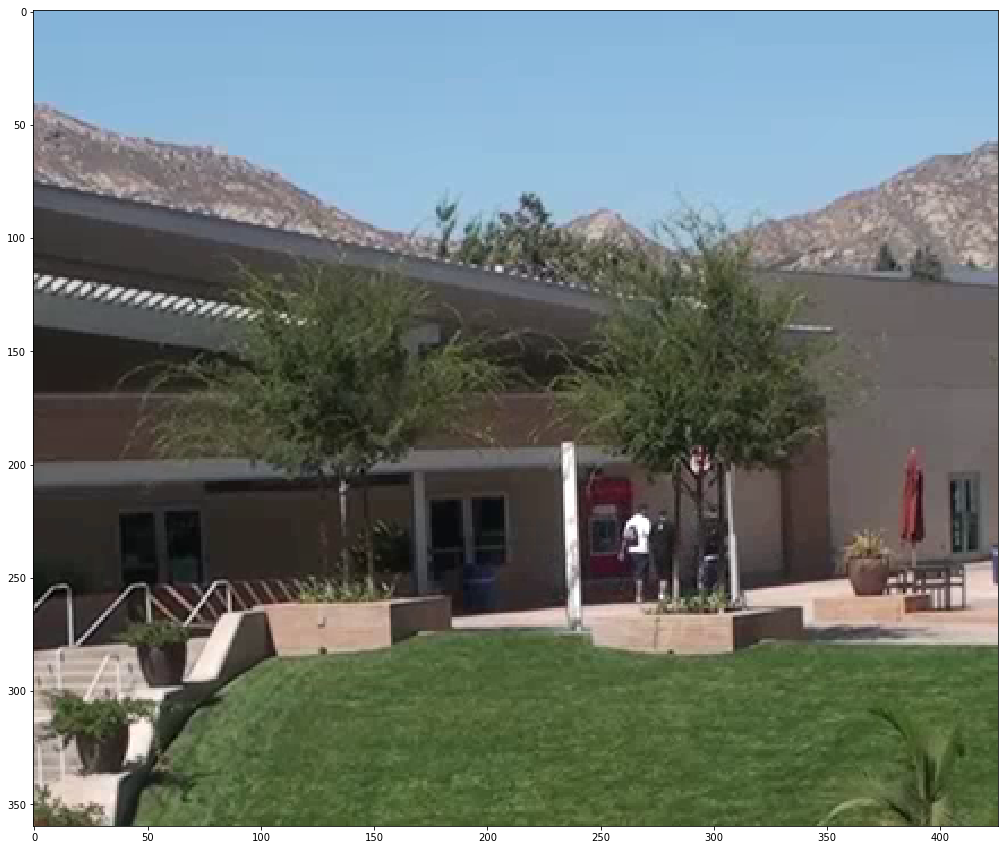

In [70]:
success, frame = vs.read()
tiles = tile_image(frame, tiles_x, tiles_y)
boxes, total_time, new_tile_draw = detect_single_frame(mobile_ssd_net, tiles[0, 1])
plt.imshow(cv2.cvtColor(new_tile_draw, cv2.COLOR_BGR2RGB))
plt.show()

In [50]:
original_frame = frame.copy()
for box in boxes:
    (startX, startY, endX, endY) = box

    cv2.rectangle(original_frame, (startX, startY), (endX, endY), (0,255,0), 2)

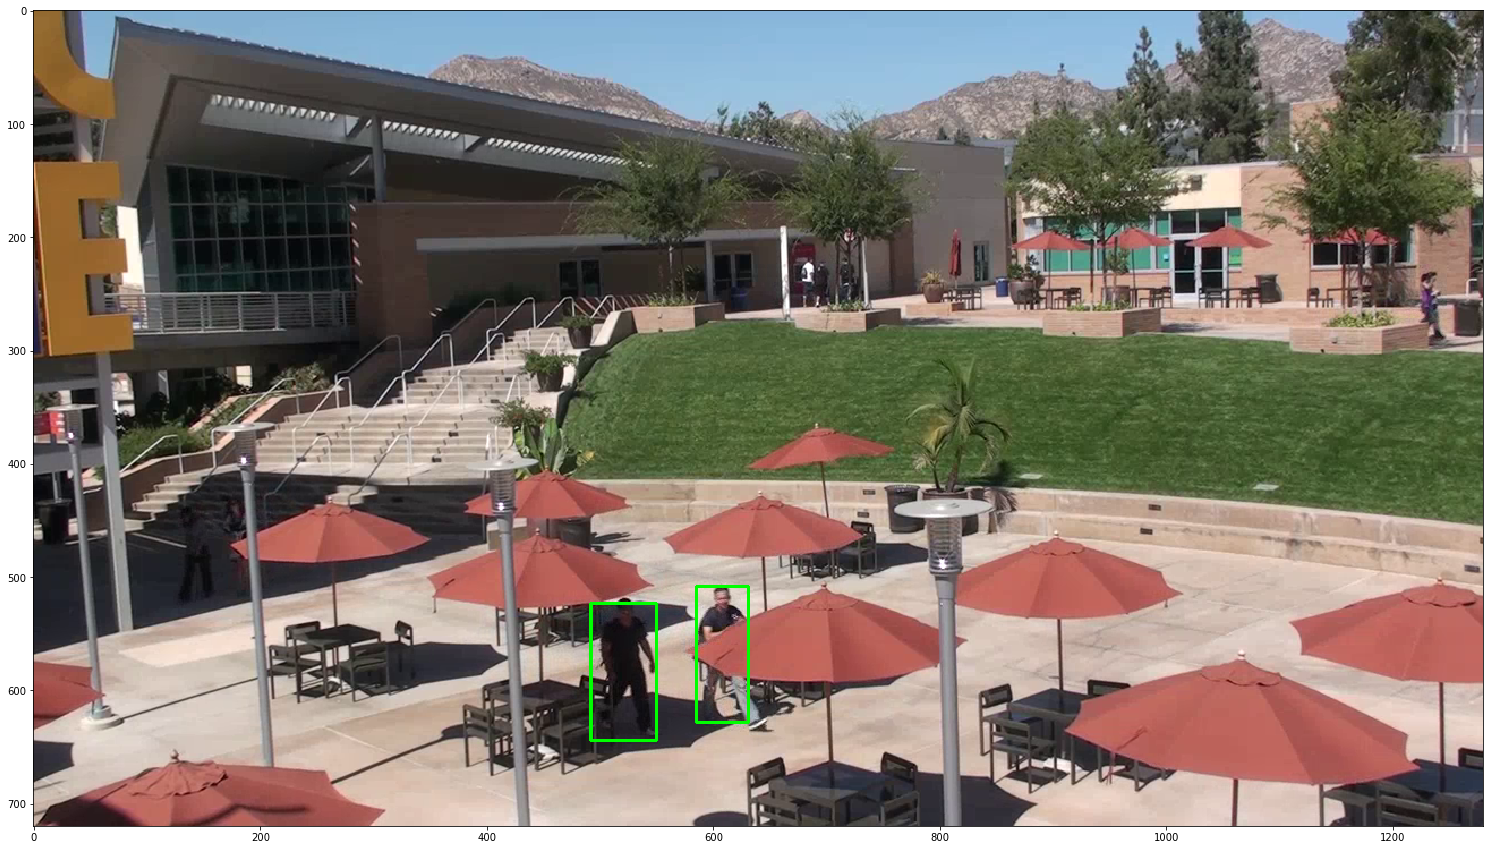

In [51]:
plt.imshow(cv2.cvtColor(original_frame, cv2.COLOR_BGR2RGB))
plt.show()

In [44]:
original_frame = frame.copy()
for box in adjusted_boxes:
    (startX, startY, endX, endY) = box

    cv2.rectangle(original_frame, (startX, startY), (endX, endY), (0,255,0), 2)

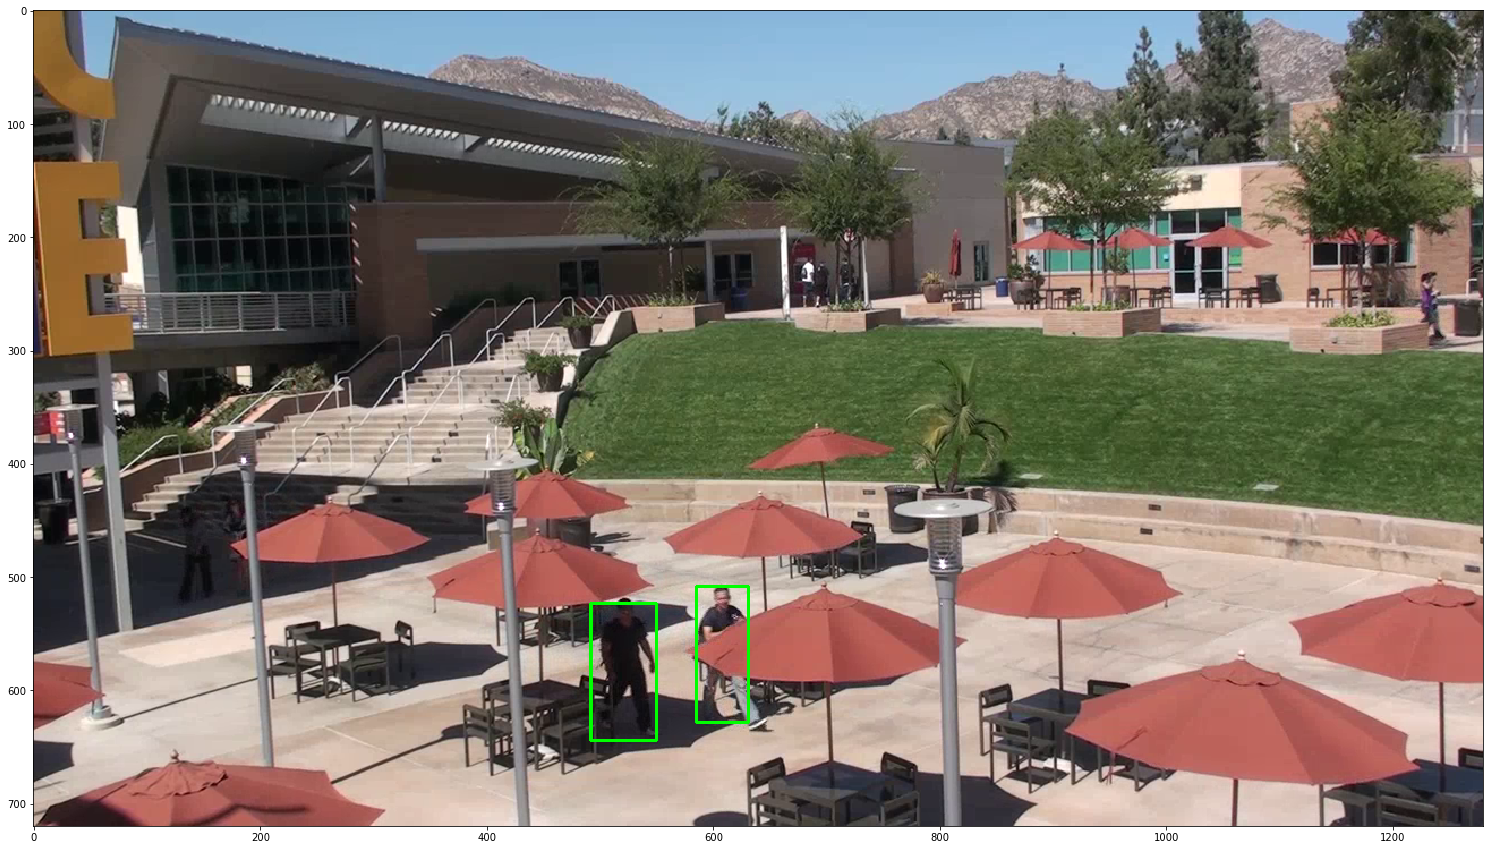

In [45]:
plt.imshow(cv2.cvtColor(original_frame, cv2.COLOR_BGR2RGB))
plt.show()

In [14]:
frame.shape

(720, 1280, 3)

In [38]:
num_rows = 30
num_columns = 50

In [17]:
frame_b =  frame[:,:,0]

In [42]:
frame_tiled = frame_b[0:12,0:16]

In [43]:
frame_tiled

array([[46, 46, 46, 46, 46, 46, 46, 46, 48, 48, 48, 48, 48, 48, 48, 48],
       [46, 46, 46, 46, 46, 46, 46, 46, 48, 48, 48, 48, 48, 48, 48, 48],
       [48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48],
       [48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 49, 49, 48, 48],
       [48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 49, 49, 48, 48],
       [49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49],
       [51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 49, 49],
       [51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 49, 48],
       [51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 49, 48],
       [51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 49, 48],
       [51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 49, 48],
       [51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 49, 48]],
      dtype=uint8)

In [44]:
frame_tiled.shape

(12, 16)

In [45]:
margin_pct = 0.25
margin_x =  int(frame_tiled.shape[0] * margin_pct)
margin_y =  int(frame_tiled.shape[1] * margin_pct)

In [46]:
margin_x

3

In [47]:
margin_y

4

In [81]:
x = 0 
y = 0
final_x = 9
final_y = 12

In [86]:
x = 1 
y = 1
final_x = 9
final_y = 12

In [71]:
x = 22
y = 40
final_x = 26
final_y = 48

In [87]:
new_x = max(0, x-margin_x)
new_y = max(0, y-margin_y)
new_final_x = min(num_rows, final_x+margin_x)
new_final_y = min(num_columns, final_y+margin_y)

In [91]:
margin_left = x - new_x
margin_top = y - new_y
margin_right = new_final_x - final_x
margin_bottom = new_final_y - final_y


In [92]:
new_x, new_y, new_final_x, new_final_y

(0, 0, 12, 16)

In [93]:
margin_left, margin_right, margin_top, margin_bottom

(1, 3, 1, 4)

In [96]:
dict_test = {(1,2,3): 4, (3,5,6):'hry'}

In [97]:
dict_test

{(1, 2, 3): 4, (3, 5, 6): 'hry'}

In [105]:
def margin_info(image, tiles_x, tiles_y, margin_percent):
    margin_dict = {}
    rect_dimension_x = image.shape[0] / tiles_x
    rect_dimension_y = image.shape[1] / tiles_y

    for tile_x in range(0, tiles_x):
        for tile_y in range(0, tiles_y):
            x = int(tile_x * rect_dimension_x)
            y = int(tile_y * rect_dimension_y)
            final_x = int(x + rect_dimension_x)
            final_y = int(y + rect_dimension_y)


            margin_x = int(rect_dimension_x * margin_percent)
            margin_y = int(rect_dimension_y * margin_percent)

            new_x = max(0, x - margin_x)
            new_y = max(0, y - margin_y)
            new_final_x = min(image.shape[0], final_x + margin_x)
            new_final_y = min(image.shape[1], final_y + margin_y)

            margin_left = x - new_x
            margin_top = y - new_y
            margin_right = new_final_x - final_x
            margin_bottom = new_final_y - final_y

            margin_dict[(tile_x, tile_y)] = {
                'coords': (x, y, final_x, final_y),
                'new_coords': (new_x, new_y, new_final_x, new_final_y),
                'margins_length': (margin_left, margin_top, margin_right, margin_bottom)}
    return margin_dict

In [106]:
frame.shape

(720, 1280, 3)

In [111]:
xv = margin_info(frame, 2, 3, 0.25)

In [112]:
xv

{(0, 0): {'coords': (0, 0, 360, 426),
  'margins_length': (0, 0, 90, 106),
  'new_coords': (0, 0, 450, 532)},
 (0, 1): {'coords': (0, 426, 360, 852),
  'margins_length': (0, 106, 90, 106),
  'new_coords': (0, 320, 450, 958)},
 (0, 2): {'coords': (0, 853, 360, 1279),
  'margins_length': (0, 106, 90, 1),
  'new_coords': (0, 747, 450, 1280)},
 (1, 0): {'coords': (360, 0, 720, 426),
  'margins_length': (90, 0, 0, 106),
  'new_coords': (270, 0, 720, 532)},
 (1, 1): {'coords': (360, 426, 720, 852),
  'margins_length': (90, 106, 0, 106),
  'new_coords': (270, 320, 720, 958)},
 (1, 2): {'coords': (360, 853, 720, 1279),
  'margins_length': (90, 106, 0, 1),
  'new_coords': (270, 747, 720, 1280)}}

In [114]:
xv[0,1]['new_coords']

(0, 320, 450, 958)